#### Copyright 2018 Google LLC.

In [ ]:
# Лицензия Apache версии 2.0 («Лицензия»);
# вы не можете использовать этот файл, кроме как в соответствии с Лицензией.
# Вы можете получить копию Лицензии по адресу
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Если это не требуется действующим законодательством или не согласовано в письменной форме, программное обеспечение
# распространяется по Лицензии, распространяется на условиях «КАК ЕСТЬ»,
# БЕЗ КАКИХ-ЛИБО ГАРАНТИЙ ИЛИ УСЛОВИЙ, явных или подразумеваемых.
# См. лицензию для конкретного языка, регулирующего разрешения и
# ограничений по Лицензии.

# Cat vs. Dog Image Classification
## Упражнение 1. Создание Convnet с нуля
**_Расчетное время выполнения: 20 минут_**

В этом упражнении мы с нуля построим модель классификатора, которая сможет отличать собак от кошек. Мы выполним следующие шаги:

1. Изучите данные примера
2. Создайте небольшую сеть с нуля, чтобы решить нашу проблему классификации.
3. Оцените точность обучения и проверки.

Вперед!

## Изучите пример данных

Давайте начнем с загрузки данных нашего примера — ZIP-файла с 2000 изображениями кошек и собак в формате JPG и его локального извлечения в `/tmp`.

**ПРИМЕЧАНИЕ.** 2000 изображений, использованных в этом упражнении, взяты из [набора данных «Собаки против кошек»] (https://www.kaggle.com/c/dogs-vs-cats/data), доступного на Kaggle. , который содержит 25 000 изображений. Здесь мы используем подмножество полного набора данных, чтобы сократить время обучения в образовательных целях.

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2023-09-20 13:58:14--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.182.207, 64.233.183.207, 173.194.193.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.182.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   222MB/s    in 0.3s    

2023-09-20 13:58:15 (222 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Содержимое ZIP-архива извлекается в базовый каталог `/tmp/cats_and_dogs_filtered`, который содержит подкаталоги `train` и `validation` для наборов данных обучения и проверки (см. [Ускоренный курс машинного обучения] (https://developers .google.com/machine-learning/crash-course/validation/check-your-intuition) для ознакомления с обучающими, проверочными и тестовыми наборами), каждый из которых, в свою очередь, содержит подкаталоги `cats` и `dogs`. Давайте определим каждый из этих каталогов:

In [3]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Каталог с фотографиями наших дрессированных кошек
train_cats_dir = os.path.join(train_dir, 'cats')

# Каталог с фотографиями наших дрессировочных собак
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Каталог с нашими проверочными фотографиями кошек
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Каталог с фотографиями наших проверочных собак
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

Теперь давайте посмотрим, как выглядят имена файлов в каталогах `cats` и `dogs` `train` (в каталоге `validation` правила именования файлов такие же):

In [4]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.612.jpg', 'cat.576.jpg', 'cat.486.jpg', 'cat.557.jpg', 'cat.856.jpg', 'cat.314.jpg', 'cat.913.jpg', 'cat.841.jpg', 'cat.663.jpg', 'cat.138.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


Выясним общее количество изображений кошек и собак в каталогах `train` и `validation`:

In [5]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


И для кошек, и для собак у нас есть 1000 обучающих изображений и 500 тестовых изображений.

Теперь давайте взглянем на несколько фотографий, чтобы лучше понять, как выглядят наборы данных о кошках и собаках. Сначала настройте параметры матплота:

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Параметры нашего графика; мы выведем изображения в конфигурации 4x4
nrows = 4
ncols = 4

# Индекс для перебора изображений
pic_index = 0

Теперь покажите группу из 8 изображений кошек и 8 собак. Вы можете повторно запустить ячейку, чтобы каждый раз видеть новую партию:

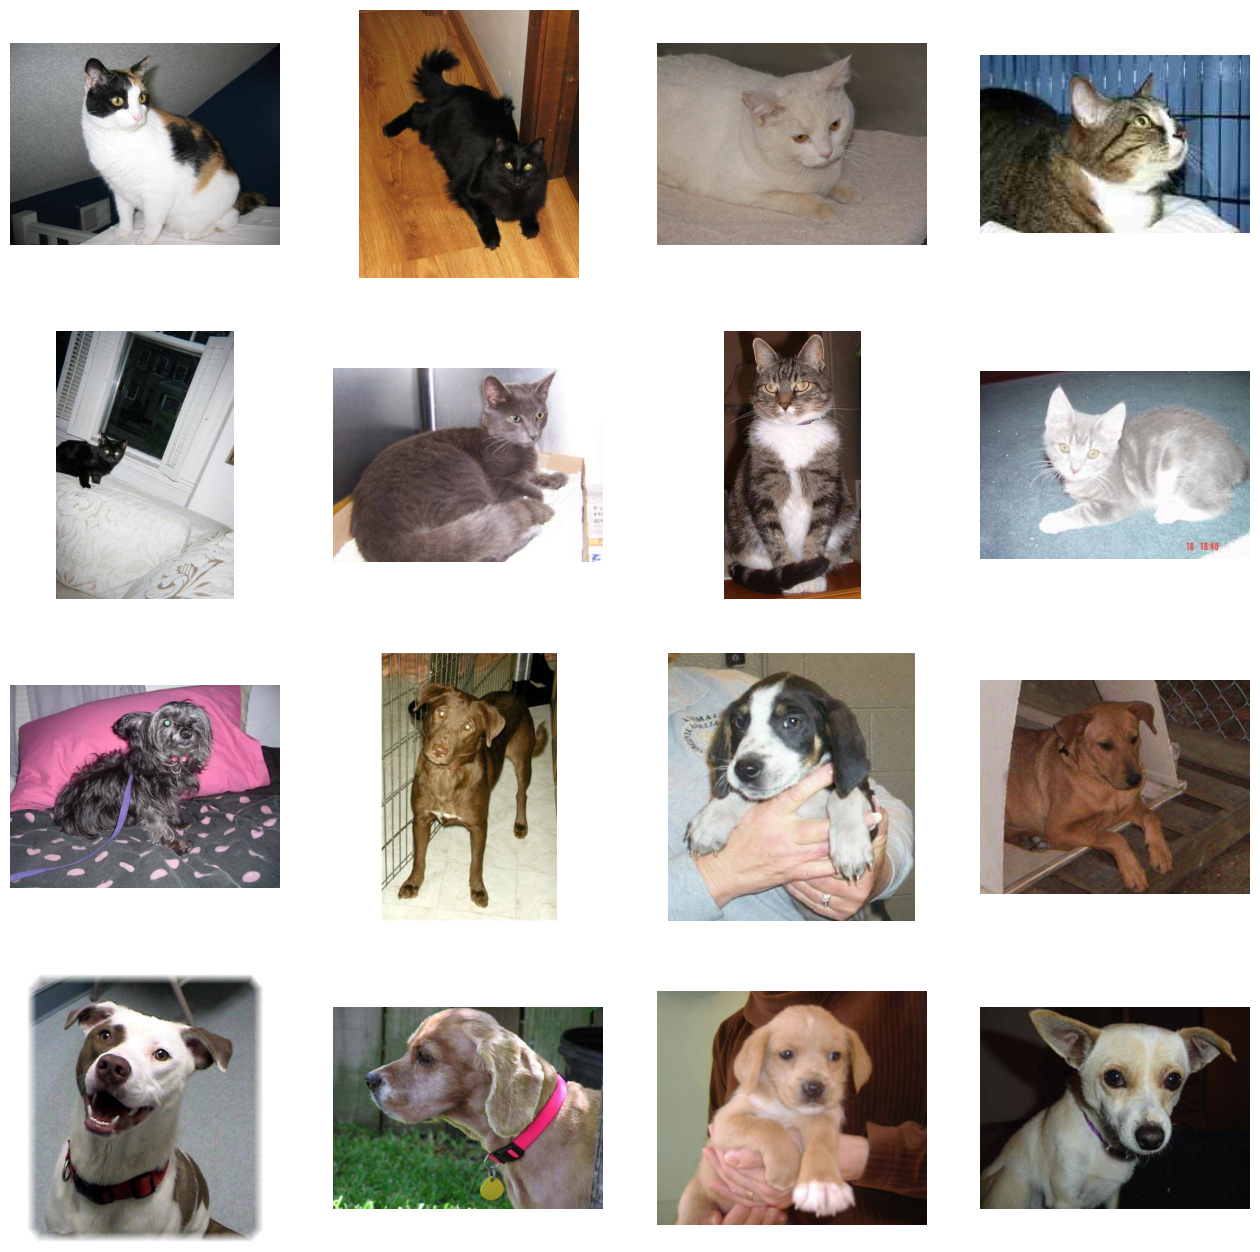

In [7]:
# Настройте рисунок matplotlib и измените его размер так, чтобы он соответствовал изображениям 4x4.
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname)
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname)
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Настроить подсюжет; индексы подграфиков начинаются с 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Не показывать оси (или линии сетки)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


## Создание небольшой сети с нуля для достижения точности 72%

Изображения, которые попадут в нашу сеть, представляют собой цветные изображения размером 150x150 (в следующем разделе, посвященном предварительной обработке данных, мы добавим обработку для изменения размера всех изображений до 150x150 перед подачей их в нейронную сеть).

Давайте закодируем архитектуру. Мы сложим 3 модуля {convolution + relu + maxpooling}. Наши свертки работают с окнами 3x3, а слои maxpooling — с окнами 2x2. Наша первая свертка извлекает 16 фильтров, следующая — 32 фильтра, а последняя — 64 фильтра.

**ПРИМЕЧАНИЕ**. Эта конфигурация широко используется и хорошо работает для классификации изображений. Кроме того, поскольку у нас относительно мало обучающих примеров (1000), использование всего трех сверточных модулей сохраняет размер модели, что снижает риск переобучения (который мы рассмотрим более подробно в упражнении 2).

In [8]:
from tensorflow.keras import layers
from tensorflow.keras import Model

In [9]:
# Наша входная карта объектов имеет размер 150x150x3: 150x150 для пикселей изображения и 3 для
# три цветовых канала: R, G и B
img_input = layers.Input(shape=(150, 150, 3))

# Первая свертка извлекает 16 фильтров размером 3х3
# За сверткой следует слой максимального пула с окном 2х2.
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Вторая свертка извлекает 32 фильтра размером 3х3
# За сверткой следует слой максимального пула с окном 2х2.
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Третья свертка извлекает 64 фильтра размером 3х3
# За сверткой следует слой максимального пула с окном 2х2.
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

Поверх него наклеиваем два цельносоединенных слоя. Поскольку мы столкнулись с проблемой классификации двух классов, то есть *проблемой двоичной классификации*, мы завершим нашу сеть [*sigmoid* активацией](https://wikipedia.org/wiki/Sigmoid_function), чтобы выходные данные нашей сети будет один скаляр между 0 и 1, кодирующий вероятность того, что текущее изображение относится к классу 1 (в отличие от класса 0).

In [10]:
# Сгладить карту объектов до 1-мерного тензора, чтобы мы могли добавлять полностью связанные слои.
x = layers.Flatten()(x)

# Создайте полностью связанный слой с активацией ReLU и 512 скрытыми блоками.
x = layers.Dense(512, activation='relu')(x)

# Создайте выходной слой с одним узлом и активацией сигмоида.
output = layers.Dense(1, activation='sigmoid')(x)

# Создать модель:
# input = входная карта объектов
# вывод = входная карта объектов + сложенные слои свертки/макспулинга + полностью
# подключенный слой + выходной слой сигмовидной кишки
model = Model(img_input, output)

Подведем итоги архитектуры модели:

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496 

Столбец «Выходная форма» показывает, как изменяется размер вашей карты объектов на каждом последующем слое. Слои свертки немного уменьшают размер карт объектов за счет заполнения, и каждый слой объединения уменьшает карту объектов вдвое.

Далее мы настроим спецификации для обучения модели. Мы будем обучать нашу модель с потерей `binary_crossentropy`, потому что это проблема двоичной классификации, и наша конечная активация — это сигмоида. (Для повышения квалификации по показателям потерь см. [Ускоренный курс машинного обучения](https://developers.google.com/machine-learning/crash-course/descending-into-ml/video-lecture).) Мы будем использовать оптимизатор rmsprop со скоростью обучения 0,001. Во время обучения мы хотим контролировать точность классификации.

**ПРИМЕЧАНИЕ**. В этом случае использование [алгоритма оптимизации RMSprop](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) предпочтительнее [стохастического градиентного спуска](https://developers.google.com /machine-learning/glossary/#SGD) (SGD), потому что RMSprop автоматизирует для нас настройку скорости обучения. (Другие оптимизаторы, такие как [Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) и [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad), также автоматически адаптирует скорость обучения во время обучения и здесь будет работать одинаково хорошо.)

In [12]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

### Предварительная обработка данных

Давайте настроим генераторы данных, которые будут считывать изображения в наших исходных папках, преобразовывать их в тензоры float32 и передавать их (вместе с метками) в нашу сеть. У нас будет один генератор для обучающих изображений и один для проверочных изображений. Наши генераторы будут генерировать пакеты из 20 изображений размером 150x150 и их метки (двоичные).

Как вы, возможно, уже знаете, данные, поступающие в нейронные сети, обычно должны быть каким-то образом нормализованы, чтобы сделать их более пригодными для обработки сетью. (Необработанные пиксели подаются в коннет редко.) В нашем случае мы будем предварительно обрабатывать наши изображения, нормализуя значения пикселей так, чтобы они находились в диапазоне `[0, 1]` (изначально все значения находятся в диапазоне `[0, 1]` 255]` диапазон).

В Keras это можно сделать с помощью класса keras.preprocessing.image.ImageDataGenerator с использованием параметра rescale. Этот класс ImageDataGenerator позволяет создавать экземпляры генераторов дополненных пакетов изображений (и их меток) через .flow(data, labels) или .flow_from_directory(directory)`. Эти генераторы затем можно использовать с методами модели Keras, которые принимают генераторы данных в качестве входных данных: fit_generator, evaluate_generator и predict_generator.

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Все изображения будут масштабированы на 1./255.
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Поток обучающих изображений партиями по 20 штук с использованием генератора train_datagen
train_generator = train_datagen.flow_from_directory(
        train_dir,  # Это исходный каталог для обучающих изображений
        target_size=(150, 150),  # Размер всех изображений будет изменен до 150x150.
        batch_size=20,
        # Поскольку мы используем потерю бинарной_кроссэнтропии, нам нужны двоичные метки
        class_mode='binary')

# Изображения для проверки потока пакетами по 20 с использованием генератора val_datagen
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Обучение
Давайте обучим все 2000 доступных изображений в течение 15 эпох и проверим все 1000 проверочных изображений. (Это может занять несколько минут.)

In [14]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=15,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

Epoch 1/15


<ipython-input-14-91d346d1b720>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


100/100 - 17s - loss: 0.6928 - acc: 0.5345 - val_loss: 0.6575 - val_acc: 0.6330 - 17s/epoch - 168ms/step
Epoch 2/15
100/100 - 6s - loss: 0.6389 - acc: 0.6460 - val_loss: 0.6236 - val_acc: 0.6380 - 6s/epoch - 55ms/step
Epoch 3/15
100/100 - 5s - loss: 0.5666 - acc: 0.6985 - val_loss: 0.5759 - val_acc: 0.7050 - 5s/epoch - 54ms/step
Epoch 4/15
100/100 - 5s - loss: 0.5179 - acc: 0.7470 - val_loss: 0.5616 - val_acc: 0.7050 - 5s/epoch - 47ms/step
Epoch 5/15
100/100 - 5s - loss: 0.4654 - acc: 0.7760 - val_loss: 0.6078 - val_acc: 0.6850 - 5s/epoch - 46ms/step
Epoch 6/15
100/100 - 5s - loss: 0.3992 - acc: 0.8225 - val_loss: 0.5747 - val_acc: 0.7130 - 5s/epoch - 55ms/step
Epoch 7/15
100/100 - 5s - loss: 0.3363 - acc: 0.8515 - val_loss: 0.5879 - val_acc: 0.7180 - 5s/epoch - 55ms/step
Epoch 8/15
100/100 - 5s - loss: 0.2665 - acc: 0.8810 - val_loss: 0.7923 - val_acc: 0.6920 - 5s/epoch - 47ms/step
Epoch 9/15
100/100 - 6s - loss: 0.1845 - acc: 0.9265 - val_loss: 0.7568 - val_acc: 0.7140 - 6s/epoch - 5

### Визуализация промежуточных представлений

Чтобы получить представление о том, какие функции усвоил наш коннет, можно сделать одну интересную вещь — визуализировать, как входные данные преобразуются по мере прохождения через коннет.

Давайте выберем случайное изображение кошки или собаки из обучающего набора, а затем сгенерируем фигуру, где каждая строка является выходными данными слоя, а каждое изображение в строке представляет собой определенный фильтр в этой выходной карте объектов. Повторно запустите эту ячейку, чтобы сгенерировать промежуточные представления для различных обучающих изображений.

1/1 [==============================] - 0s 265ms/step


<ipython-input-15-a8f8c303504b>:43: RuntimeWarning: invalid value encountered in divide
  x /= x.std()


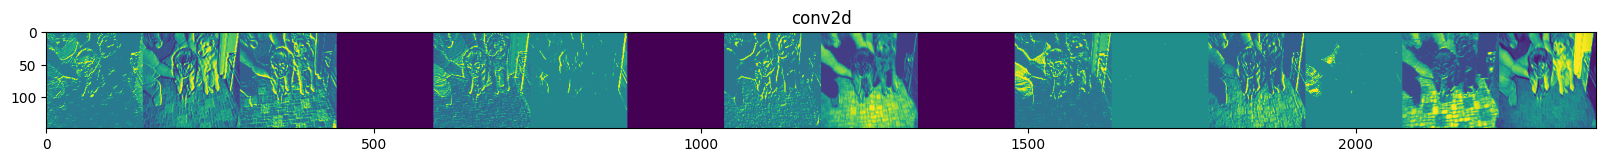

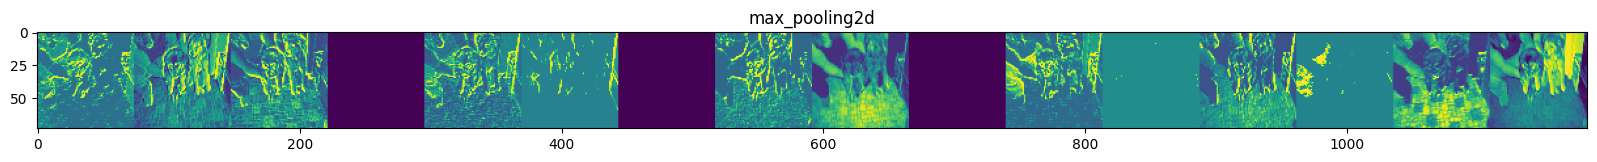

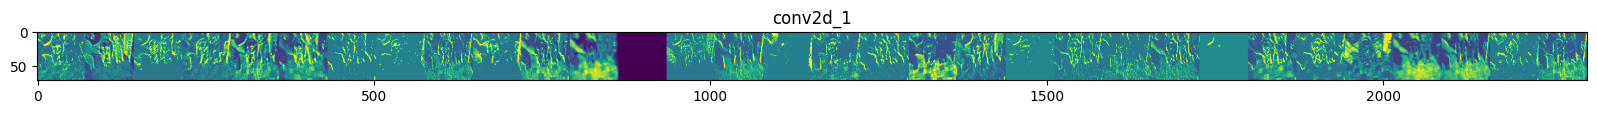

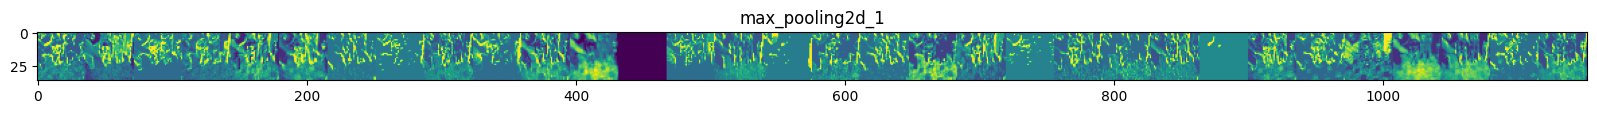

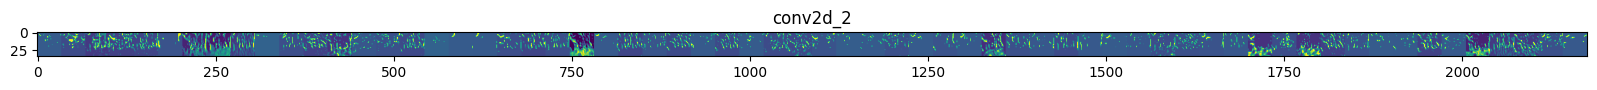

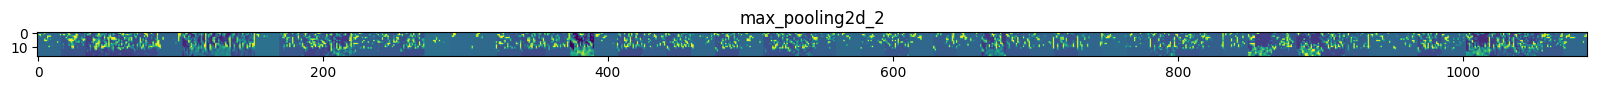

In [15]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Давайте определим новую модель, которая будет принимать изображение в качестве входных данных и выводить
# промежуточные представления для всех слоев предыдущей модели после
# первый.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(img_input, successive_outputs)

# Давайте подготовим случайное входное изображение кошки или собаки из обучающего набора.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]
img_path = random.choice(cat_img_files + dog_img_files)

img = load_img(img_path, target_size=(150, 150)) # это PIL-изображение
x = img_to_array(img)  # Массив Numpy с формой (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Массив Numpy с формой (1, 150, 150, 3)

# Изменение масштаба на 1/255
x /= 255

# Пропустим наш образ через нашу сеть, получив таким образом все
# промежуточные представления для этого изображения.
successive_feature_maps = visualization_model.predict(x)

# Это названия слоев, поэтому они могут быть частью нашего сюжета.
layer_names = [layer.name for layer in model.layers[1:]]

# Теперь давайте отобразим наши представления
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Просто сделайте это для слоев conv/maxpool, а не для полностью связанных слоев
    n_features = feature_map.shape[-1]  # количество объектов на карте объектов
    # Карта объектов имеет форму (1, размер, размер, n_features)
    size = feature_map.shape[1]
    # Мы разместим наши изображения в этой матрице
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Постобработка функции, чтобы сделать ее визуально привлекательной
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # Мы разместим каждый фильтр в этой большой горизонтальной сетке
      display_grid[:, i * size : (i + 1) * size] = x
    # Отображение сетки
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

Как видите, мы переходим от необработанных пикселей изображений к все более абстрактным и компактным представлениям. Представления ниже по течению начинают подчеркивать то, на что сеть обращает внимание, и они показывают все меньше и меньше «активируемых» функций; большинство из них установлены на ноль. Это называется «разреженность». Разреженность представлений — ключевая особенность глубокого обучения.


Эти представления несут все меньше информации об исходных пикселях изображения, но все более точную информацию о классе изображения. Вы можете думать о сети (или глубокой сети в целом) как о конвейере обработки информации.

### Оценка точности и потерь модели

Давайте построим график точности и потерь обучения/проверки, собранных во время обучения:

Text(0.5, 1.0, 'Training and validation loss')

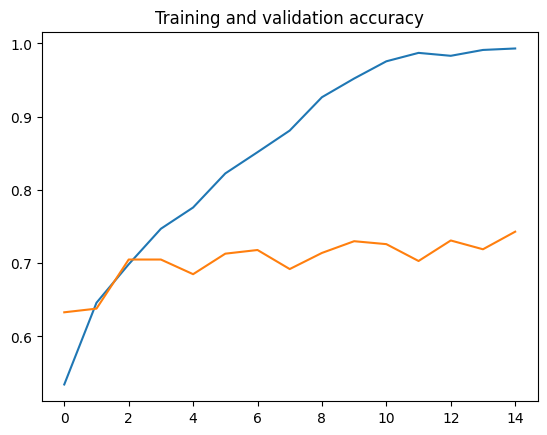

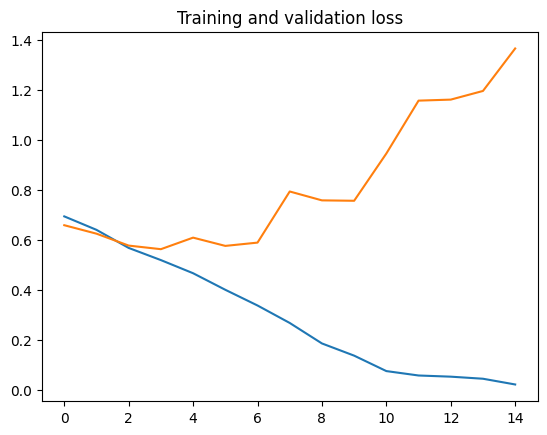

In [16]:
# Получить список результатов точности данных обучения и проверки
# комплектов для каждой эпохи обучения
acc = history.history['acc']
val_acc = history.history['val_acc']

# Получить список результатов по данным обучения и проверки
# комплектов для каждой эпохи обучения
loss = history.history['loss']
val_loss = history.history['val_loss']

# Получить количество эпох
epochs = range(len(acc))

# График обучения и точности проверки за эпоху
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Построение графика потерь при обучении и проверке за эпоху
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

Как видите, мы **переоснащаемся**, как будто это выходит из моды. Наша точность обучения (синий цвет) приближается к 100% (!), тогда как точность проверки (зеленый цвет) колеблется на уровне 70%. Наши потери при проверке достигают минимума всего через пять эпох.

Поскольку у нас относительно небольшое количество обучающих примеров (2000 г.), переобучение должно быть нашей заботой номер один. Переоснащение происходит, когда модель, на которой представлено слишком мало примеров, изучает закономерности, которые не обобщаются на новые данные, т. е. когда модель начинает использовать нерелевантные функции для составления прогнозов. Например, если вы, как человек, видите только три изображения людей-лесорубов и три изображения людей-моряков, и среди них единственный человек, носящий кепку, — это лесоруб, вы можете начать думать, что носить кепку это признак того, что ты лесоруб, а не моряк. Тогда вы получите довольно паршивый классификатор лесорубов и моряков.

Переобучение — это центральная проблема машинного обучения: учитывая, что мы подгоняем параметры нашей модели к заданному набору данных, как мы можем быть уверены, что представления, полученные с помощью модели, будут применимы к данным, которых раньше не было? Как нам избежать изучения вещей, специфичных для обучающих данных?

В следующем упражнении мы рассмотрим способы предотвращения переобучения в модели классификации кошек и собак.

## Очистка

Прежде чем выполнять следующее упражнение, запустите следующую ячейку, чтобы завершить работу ядра и освободить ресурсы памяти:

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)